In [4]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
from itertools import chain
import scipy.ndimage.interpolation
import warnings
warnings.simplefilter("ignore")

In [5]:
mnist = input_data.read_data_sets('data', one_hot=True)
mb_size = 32
z_dim = 10
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
cnt = 0
lr = 1e-4
n_critics = 3
lam1, lam2 = 100, 100


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [6]:
def log(x):
    return torch.log(x + 1e-8)


G1 = torch.nn.Sequential(
    torch.nn.Linear(X_dim + z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

G2 = torch.nn.Sequential(
    torch.nn.Linear(X_dim + z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D1 = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1)
)

D2 = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1)
)


In [7]:
def reset_grad():
    G1.zero_grad()
    G2.zero_grad()
    D1.zero_grad()
    D2.zero_grad()

In [8]:
G_solver = optim.RMSprop(chain(G1.parameters(), G2.parameters()), lr=lr)
D1_solver = optim.RMSprop(D1.parameters(), lr=lr)
D2_solver = optim.RMSprop(D2.parameters(), lr=lr)

X_train = mnist.train.images
half = int(X_train.shape[0] / 2)

# Real image
X_train1 = X_train[:half]
# Rotated image
X_train2 = X_train[half:].reshape(-1, 28, 28)
X_train2 = scipy.ndimage.interpolation.rotate(X_train2, 90, axes=(1, 2))
X_train2 = X_train2.reshape(-1, 28*28)

# Cleanup
del X_train

In [9]:
def sample_x(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    return Variable(torch.from_numpy(X[start_idx:start_idx+size]))


Iter-0; D_loss: -0.1343; G_loss: 7.414e+04
Iter-1000; D_loss: -3.65; G_loss: 1.938e+04
Iter-2000; D_loss: -3.945; G_loss: 1.647e+04
Iter-3000; D_loss: -3.828; G_loss: 1.581e+04
Iter-4000; D_loss: -4.065; G_loss: 1.436e+04
Iter-5000; D_loss: -3.958; G_loss: 1.26e+04
Iter-6000; D_loss: -3.967; G_loss: 1.222e+04
Iter-7000; D_loss: -3.995; G_loss: 1.351e+04
Iter-8000; D_loss: -3.822; G_loss: 1.113e+04
Iter-9000; D_loss: -3.739; G_loss: 1.002e+04
Iter-10000; D_loss: -3.85; G_loss: 1.082e+04
Iter-11000; D_loss: -3.814; G_loss: 1.056e+04
Iter-12000; D_loss: -3.913; G_loss: 9.448e+03
Iter-13000; D_loss: -3.858; G_loss: 1.017e+04
Iter-14000; D_loss: -3.668; G_loss: 8.901e+03
Iter-15000; D_loss: -3.797; G_loss: 8.875e+03
Iter-16000; D_loss: -3.835; G_loss: 9.273e+03
Iter-17000; D_loss: -3.585; G_loss: 8.654e+03
Iter-18000; D_loss: -3.734; G_loss: 7.21e+03
Iter-19000; D_loss: -3.659; G_loss: 8.081e+03
Iter-20000; D_loss: -3.797; G_loss: 8.567e+03
Iter-21000; D_loss: -3.618; G_loss: 7.423e+03
Iter

KeyboardInterrupt: 

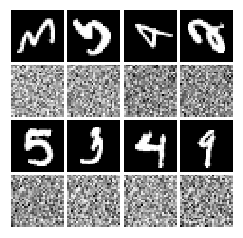

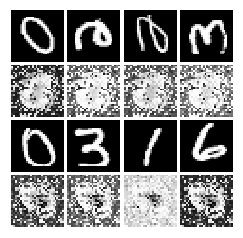

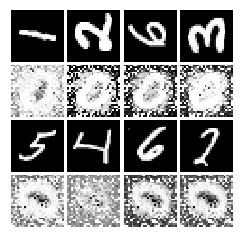

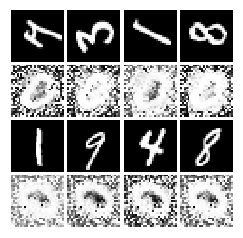

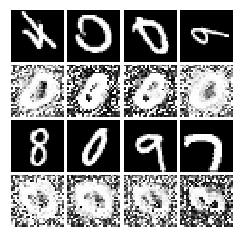

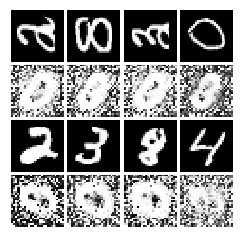

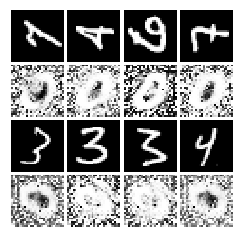

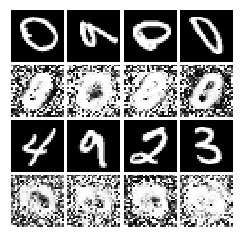

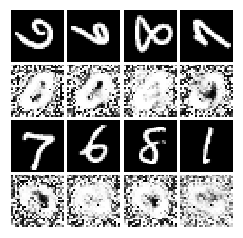

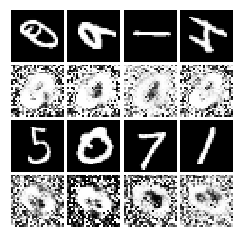

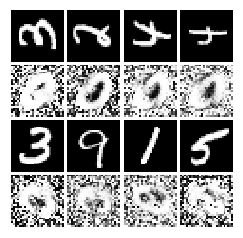

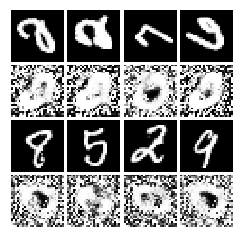

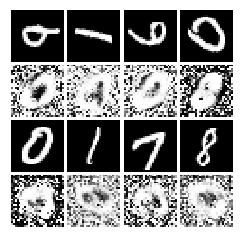

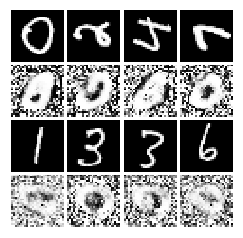

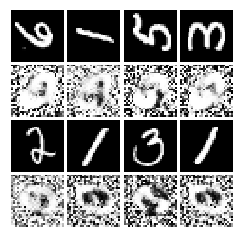

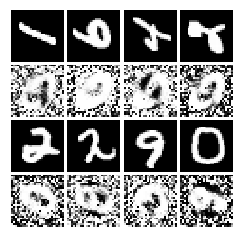

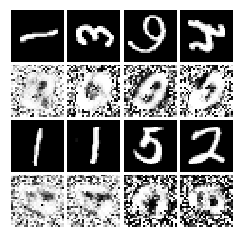

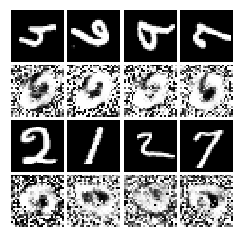

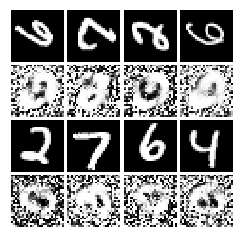

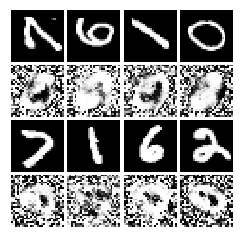

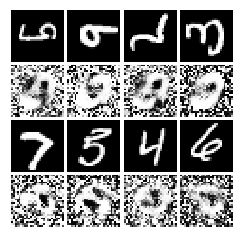

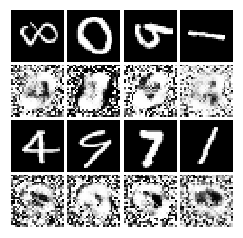

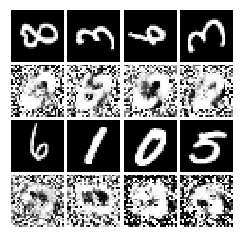

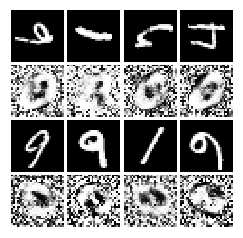

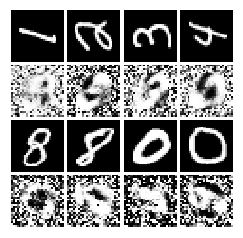

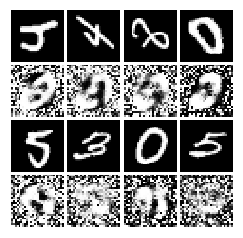

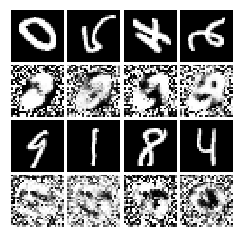

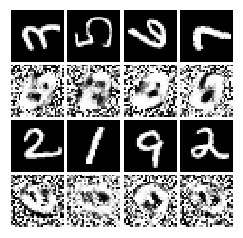

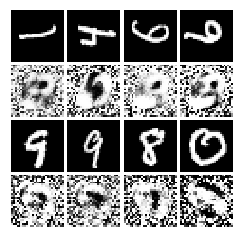

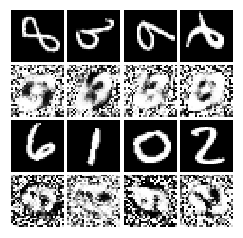

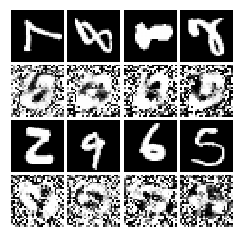

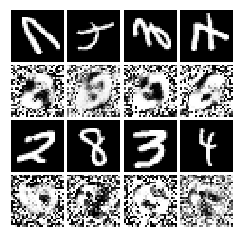

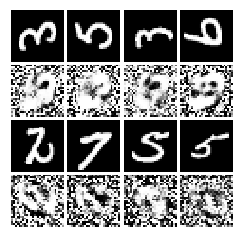

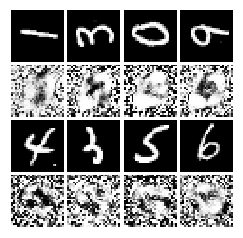

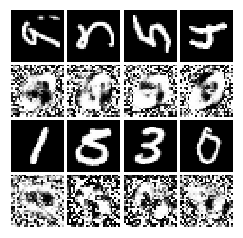

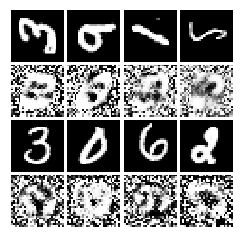

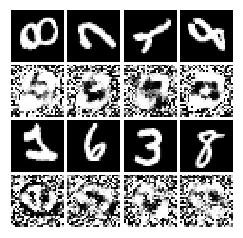

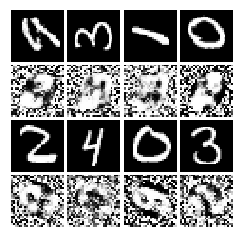

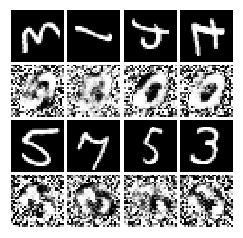

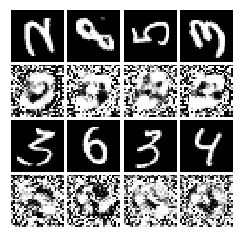

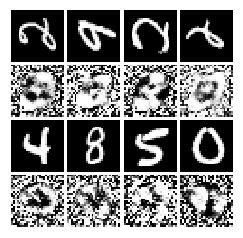

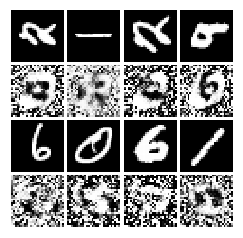

In [10]:
for it in range(1000000):
    for _ in range(n_critics):
        # Sample data
        z1 = Variable(torch.randn(mb_size, z_dim))
        z2 = Variable(torch.randn(mb_size, z_dim))
        X1 = sample_x(X_train1, mb_size)
        X2 = sample_x(X_train2, mb_size)

        # D1
        X2_sample = G1(torch.cat([X1, z1], 1))  # G1: X1 -> X2
        D1_real = D1(X2)
        D1_fake = D1(X2_sample)

        D1_loss = -(torch.mean(D1_real) - torch.mean(D1_fake))

        D1_loss.backward(retain_graph=True)
        D1_solver.step()

        # Weight clipping
        for p in D1.parameters():
            p.data.clamp_(-0.01, 0.01)

        reset_grad()

        # D2
        X1_sample = G2(torch.cat([X2, z2], 1))  # G2: X2 -> X1
        D2_real = D2(X1)
        D2_fake = D2(X1_sample)

        D2_loss = -(torch.mean(D2_real) - torch.mean(D2_fake))

        D2_loss.backward()
        D2_solver.step()

        # Weight clipping
        for p in D2.parameters():
            p.data.clamp_(-0.01, 0.01)

        reset_grad()

    # Generator
    z1 = Variable(torch.randn(mb_size, z_dim))
    z2 = Variable(torch.randn(mb_size, z_dim))
    X1 = sample_x(X_train1, mb_size)
    X2 = sample_x(X_train2, mb_size)

    X1_sample = G2(torch.cat([X2, z2], 1))
    X2_sample = G1(torch.cat([X1, z1], 1))

    X1_recon = G2(torch.cat([X2_sample, z2], 1))
    X2_recon = G1(torch.cat([X1_sample, z1], 1))

    D1_fake = D1(X1_sample)
    D2_fake = D2(X2_sample)

    G_loss = -torch.mean(D1_fake) - torch.mean(D2_fake)
    reg1 = lam1 * torch.mean(torch.sum(torch.abs(X1_recon - X1), 1))
    reg2 = lam2 * torch.mean(torch.sum(torch.abs(X2_recon - X2), 1))

    G_loss += reg1 + reg2

    G_loss.backward()
    G_solver.step()
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'
              .format(it, D1_loss.data[0] + D2_loss.data[0], G_loss.data[0]))

        real1 = X1.data.numpy()[:4]
        real2 = X2.data.numpy()[:4]
        samples1 = X1_sample.data.numpy()[:4]
        samples2 = X2_sample.data.numpy()[:4]
        samples = np.vstack([real2, samples1, real1, samples2])

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
plt.close(fig)